<a href="https://colab.research.google.com/github/Kimbaeda/youngwoo/blob/main/6%EC%9D%BC%EC%B0%A8_%EC%88%99%EC%A0%9C_word_level%EB%A1%9C_%EB%B2%88%EC%97%AD%EA%B8%B0_%EC%99%84%EC%84%B1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import os
import pandas as pd
file_path = '/content/drive/MyDrive/Colab Notebooks/자연어처리/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
lines.head()

,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


## 데이터 로드 및 전처리

In [ ]:
def preprocess_sentence(sent):
    # 소문자로 변경
    sent = sent.lower()

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [ ]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent))

have you had dinner ?
avez vous d j din ?


In [ ]:
# 총 33,000개의 샘플을 사용
num_samples = 33000

In [ ]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("/content/drive/MyDrive/Colab Notebooks/자연어처리/fra.txt", "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [ ]:
# 인코더의 입력, 디코더의 입력, 디코더의 실제값을 상위 5개 샘플만 출력
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [ ]:
# 케라스 토크나이저를 통해 단어 집합을 생성하고, 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정

tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [ ]:
# 패딩을 수행

encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

In [ ]:
# 데이터의 크기(shape) 확인

print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(33000, 8)
(33000, 16)
(33000, 16)


In [ ]:
# 샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16

In [ ]:
# 단어 집합의 크기 정의

eng_vocab_size = len(tokenizer_en.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(eng_vocab_size, fra_vocab_size))

영어 단어 집합의 크기 : 4583, 프랑스어 단어 집합의 크기 : 7414


In [ ]:
# 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다.

eng_to_index = tokenizer_en.word_index
index_to_eng = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

fra_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_fra = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

In [ ]:
# 테스트 데이터를 분리하기 전에, 적절한 분포를 갖도록 데이터를 섞어주는 과정을 진행
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 3008 19369 32509 ... 10687 11970 11210]


In [ ]:
# 이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞임

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 확인

encoder_input[30997]

array([211,  83,  62,   1,   0,   0,   0,   0], dtype=int32)

In [ ]:
decoder_input[30997]

array([   2,  115, 1975,  535,   24,   13,    8,  122,   25,    1,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_target[30997]

array([ 115, 1975,  535,   24,   13,    8,  122,   25,    1,    3,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# 115, 1975, 535, 24, 13, 8, 122, 25, 1이라는 동일 시퀀스를 확인했습니다. 이제 훈련 데이터의 10%를 테스트 데이터로 분리

In [ ]:
# num_samples = 33000

n_of_val = int(33000*0.1)
print(n_of_val)

3300


In [ ]:
# 훈련 데이터의 10%를 테스트 데이터로 분리
# 3,300개의 데이터를 테스트 데이터로 사용
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
# 훈련 데이터와 테스트 데이터의 크기(shape)를 출력
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(29700, 8)
(29700, 16)
(29700, 16)
(3300, 8)
(3300, 16)
(3300, 16)


In [ ]:
# 훈련 데이터의 샘플은 29,700개, 테스트 데이터의 샘플은 3,300개가 존재함

## 기계 번역기 만들기

In [ ]:
# 모델 설계를 위해 필요한 도구들을 임포트
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
# 임베딩 벡터와 LSTM의 은닉 상태의 크기를 특정 크기로 고정. 여기서는 50을 사용
latent_dim = 50

In [ ]:
# 인코더를 설계. Masking은 패딩 토큰인 숫자 0의 경우에는 연산을 제외하는 역할을 수행
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
# 디코더를 설계
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# 모델의 입력과 출력을 정의
# 모델 정의

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로, 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy함수가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다. 이는 케라스에서 규정한 약속입니다.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# 모델의 파라미터를 확인
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     229150      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     370700      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# 모델의 총 파라미터 개수는 1,018,364개
# 128개의 배치 크기로 총 50 에포크 학습
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

Epoch 1/50
233/233 [==============================] - 95s 376ms/step - loss: 3.1392 - acc: 0.6083 - val_loss: 1.9326 - val_acc: 0.7136
Epoch 2/50
233/233 [==============================] - 86s 368ms/step - loss: 1.7421 - acc: 0.7262 - val_loss: 1.6493 - val_acc: 0.7371
Epoch 3/50
233/233 [==============================] - 85s 367ms/step - loss: 1.5675 - acc: 0.7443 - val_loss: 1.5428 - val_acc: 0.7476
Epoch 4/50
233/233 [==============================] - 85s 366ms/step - loss: 1.4739 - acc: 0.7561 - val_loss: 1.4744 - val_acc: 0.7631
Epoch 5/50
233/233 [==============================] - 85s 365ms/step - loss: 1.3831 - acc: 0.7758 - val_loss: 1.3848 - val_acc: 0.7810
Epoch 6/50
233/233 [==============================] - 85s 366ms/step - loss: 1.3107 - acc: 0.7876 - val_loss: 1.3238 - val_acc: 0.7897
Epoch 7/50
233/233 [==============================] - 85s 366ms/step - loss: 1.2549 - acc: 0.7954 - val_loss: 1.2824 - val_acc: 0.7955
Epoch 8/50
233/233 [==============================] - 8

최종 에포크에서 훈련 데이터는 88%의 정확도를, 테스트 데이터에서는 85%의 정확도

## seq2seq 기계 번역기 동작시키기

seq2seq는 훈련 과정과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 많이 수정해야 합니다.

In [ ]:
# 테스트를 위해 모델 재설계
# 인코더

encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [ ]:
# 테스트 과정을 위한 모델 설계

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
# 테스트 과정에서의 동작을 위한 decode_sequence 함수를 구현

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_fra[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 결과 확인을 위한 함수

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2eng(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_eng[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2fra(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra_to_index['<sos>']) and i!=fra_to_index['<eos>']):
            temp = temp + index_to_fra[i] + ' '
    return temp

In [ ]:
# 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2eng(encoder_input_train[seq_index]))
  print("번역문 :",seq2fra(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  he gave me a hint . 
번역문 : il me donna un indice . 
예측문 :  il me a donn un coup de lui . 


원문 :  don t forget that . 
번역문 : n oublie pas cela . 
예측문 :  ne l a pas a . 


원문 :  you re too skinny . 
번역문 : vous tes trop maigrichons . 
예측문 :  vous tes trop . 


원문 :  how do you do this ? 
번역문 : comment fais tu ceci ? 
예측문 :  comment vous a ? 


원문 :  let me check . 
번역문 : laissez moi contr ler . 
예측문 :  laisse moi v rifier . 




In [ ]:
# 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2eng(encoder_input_test[seq_index]))
  print("번역문 :",seq2fra(decoder_input_test[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  get out ! 
번역문 : vers l ext rieur ! 
예측문 :  d gage ! 


원문 :  i don t fear death . 
번역문 : je ne crains pas la mort . 
예측문 :  il ne m a pas faim . 


원문 :  i laughed a lot . 
번역문 : j ai beaucoup ri . 
예측문 :  j ai t entendu . 


원문 :  are you in love ? 
번역문 : es tu amoureux ? 
예측문 :  tes vous pla t ? 


원문 :  i must be blind . 
번역문 : il faut que je sois aveugle . 
예측문 :  il me faut y aller . 




## 글자 단위(Character-level)로 인코더랑 디코더 비슷하게 만들어서 decode_sequence 함수 실행


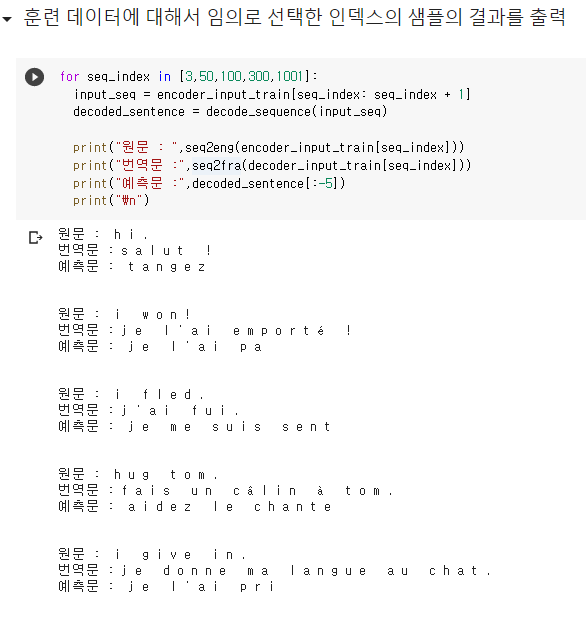

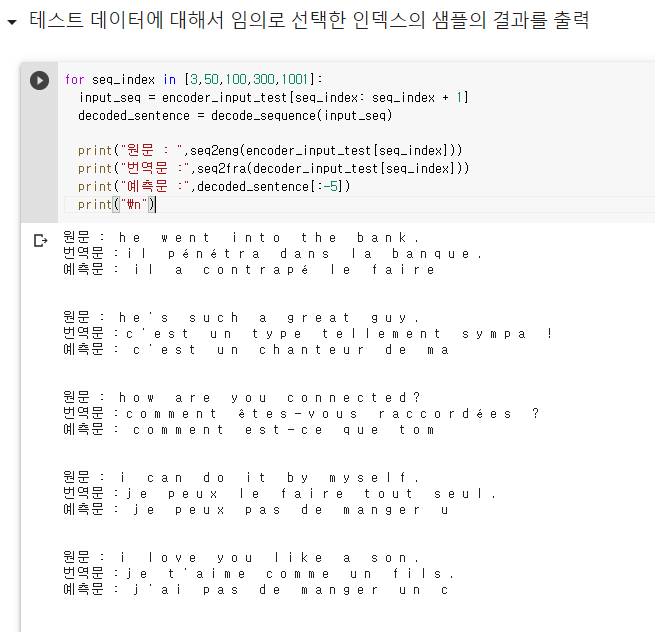